In [18]:
#@title Ses Kaydet { display-mode: "form" }
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?

record(3)

from IPython.display import Audio, display

display(Audio("audio.wav", autoplay=True))

<IPython.core.display.Javascript object>

In [15]:
!pip install transformers
!pip install torchaudio
!pip install pvrecorder
!pip install matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at m3hrdadfi/wav2vec2-large-xlsr-turkish were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeq

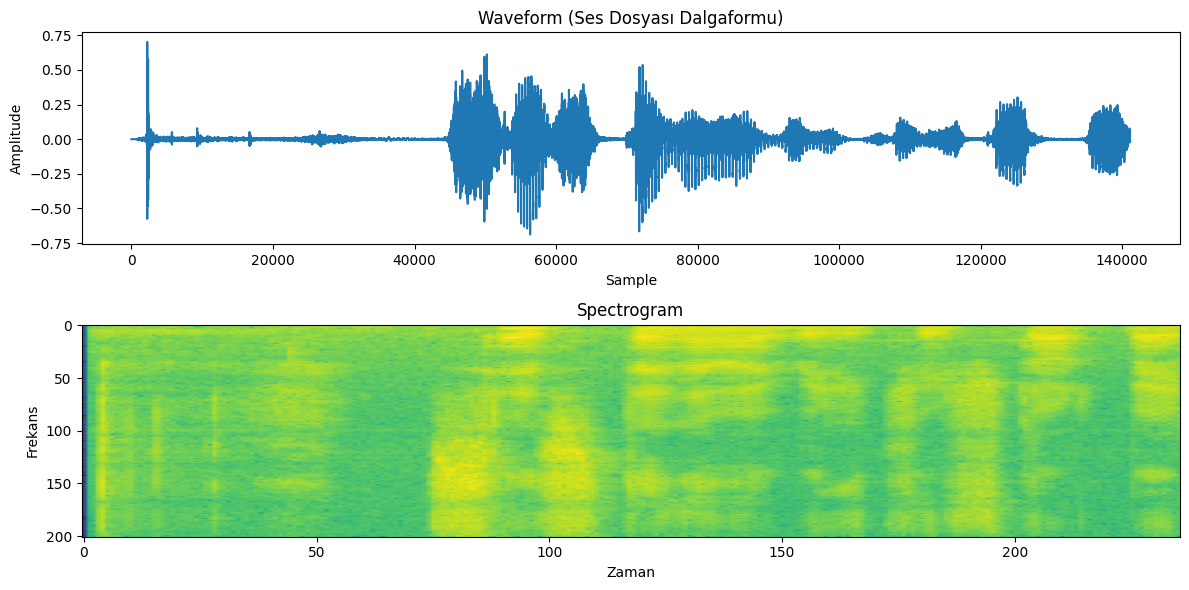

Komutunuz: ['sez dene ay bir iki üç dört ve']


In [19]:

import torch
import torchaudio

from transformers import AutoProcessor, AutoModelForCTC
import matplotlib.pyplot as plt

processor = AutoProcessor.from_pretrained("m3hrdadfi/wav2vec2-large-xlsr-turkish")
model = AutoModelForCTC.from_pretrained("m3hrdadfi/wav2vec2-large-xlsr-turkish")



waveform, sample_rate = torchaudio.load("audio.wav")
waveform_resampled = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(waveform.t().numpy())
plt.title('Waveform (Ses Dosyası Dalgaformu)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
spe = torchaudio.transforms.Spectrogram()(waveform_resampled)
spe_ch1 = spe[0, :, :]
plt.imshow(spe_ch1.log2().numpy(), aspect='auto', cmap='viridis')
plt.title('Spectrogram')
plt.xlabel('Zaman')
plt.ylabel('Frekans')

plt.tight_layout()
plt.show()

with torch.no_grad():
    logits = model(waveform_resampled).logits

output_ids = torch.argmax(logits, dim=-1)
command = processor.batch_decode(output_ids)

print("Komutunuz:", command)
